# Freedom of Information Law Opinions

-----

## Table of Contents

[Download the Data](#Data)

- [Data Preprocessing](#Prepare-Data-Structures)

[Non-Negative Matrix Factorization](#Non-Negative-Matrix-Factorization)

- [Parameter Tuning](#Tuning-the-Parameters)
- [Topic Generation](#Topics)

[Investigate Topics](#Evaluating-the-Topic-Determinations)

- [Data Visualization](#Visualizing-Topics)
- [Noise Reduction](#Reducing-Noise)

[Topic and Document Fingerprints](#Topic-and-Document-Fingerprints)
- [Finding Similar Documents](#Find-Documents-with-Matching-Topic-Fingerprints)



## Topic Modeling

While the Committee sorts their important Opinions into major content topics, like "Abstention from Voting" or "Tape Recorders, Use of," there are other topics contained in those documents—topics that could be useful to lawyers or citizens or politicians to understand and group together. An informed researcher pouring over the documents could come up with a dozen topics within each document. In this sense, we can think of documents as a recipe with topics as its ingredients:

> **Advisory Opinion 8762 Recipe**

> 1 cup describing the Audit Committee

> 2 cups clarifying the Statute of Limitations

> 1.5 tablespoons quoting §260-a of the Education Law

> 1 teaspoon invoking  *French v. Board of Education*


But there really aren't that many experts on New York State Freedom of Information Law Advisory Committee Opinions. And unfortunately, none of them are available for hundreds of hours of document classification. Instead, we can computationally infer these topics by looking at the kinds of words used in an Opinion and then comparing those word choices to the words used in all of the Opinions. By doing this over and over again, and applying different statistics to the results, one can generate latent topics, see how similar two Opinions are to one another, or determine how likely a new Opinion is to fit into one of our topics.

With enough data, we could determine how likely a given request is to get a favorable Opinion, or which court cases are most likely to help an appeal. But first, let's discover topics in the already available Opinions from the Committee. 

------------

If you want to follow along and didn't run the webscraping notebook to generate the data, you can get the data by running the following Data code cell:


<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


## Data

In [50]:
import requests
import pickle

# Finding and defining your home directory
home_dir = !echo $HOME
home = home_dir[0] +'/'

#downloading the pickled data and writing it to a file in your home directory
url = 'http://cpanel.ischool.illinois.edu/~adryden3/FOILAdvisoryDecisiondataWithText.pickle'
r = requests.get(url, allow_redirects=True)  
with open(home + 'FOILdata.pickle', 'wb') as f:
    f.write(r.content)

#reading the data and unpickeling it into a variable
with open(home + 'FOILdata.pickle', 'rb') as g:
    opinions = pickle.load(g)
    
#remove the data_dict related to this data's provenance  
if 'data_dictionary' in opinions:
    opinions.pop('data_dictionary')

In [51]:
#set up the notebook and required libraries 
% matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

-----

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


## Prepare Data Structures
The pickled file includes a clean-text version of the Advisory Opinions from the web scraping notebook. From these, we generate a list of Opinions and two indexes to help us interpret the results. The indexes represent the keywords or topics that Advisory Committee members applied to the Opinions. 

-----

In [52]:
#create indexes to use in dataframes later
human_topics = []
human_topic_number = []

#generate a list of the plain-text opinions
#skip any opinions where the full text isn't available 
opinions_list = []

number = -1
for key in opinions:
    number+=1
    human_topics.append(key)
    if len(opinions[key][3])==0:
        number-=1
        human_topics.pop()
    else:
        for i in range(len(opinions[key][3])):
            opinions_list.append(opinions[key][3][i])
            human_topic_number.append(number)
            

-----

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


### Generate TF:IDF 
 
The first machine learning process we are going to use looks at documents as a collection of words, and we serve it that collection as a list of terms, or matrix, and their frequency. To account for the fact that some words are more common than others, the frequency statistic for a term in a document is increased the more times it is mentioned in the document, and it is decreased the more times it is mentioned in the corpus. This way, rare but meaningful terms aren't drowned out by more common ones.

Words that appear in more than 90% of the documents aren't considered at all, and common or functional words that don't independently encode a lot of information ('the', 'it', 'for') are also removed. 

-----

In [53]:

# Use TD-IDF on opinions corpus
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(stop_words = 'english',
                     lowercase=True,
                     min_df=1,
                     max_df=0.9,
                     max_features=5000)



opinion_vector = cv.fit_transform(opinions_list)

-----

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


## Non-Negative Matrix Factorization 
 
Matrix factorization is like numerical factorization (the factors of 12 are the numbers that can be multiplied to equal 12: 2x6, 3x4). This algorithm takes the TF-IDF term matrices that we produced and yeilds the matrix factors, significantly reducing their dimensions in the process. This factoring has an inherent clustering effect because it computationally reduces documents to component relationships among their terms. 






### Tuning the Parameters
 
Unsupervised learning techniques can do a remarkable amount of work, but they can't always do everything. Here, we must indicate how many topics to find in the corpus. This is one of the most important aspects of this type of data analysis and usually requires some degree of domain knowledge and some experimetation. Different domains will inherently have different topic ranges, but you don't want to ask for so many topics that each document is its own topic, nor do you want to get topics that are so generic that they don't reveal anything meaningful about documents and clusters. For this domain, I felt 60 topics was appropriate because the corpus is made up of very specific requests, and therefore has a lot of granular detail that can be explored. In addition, the tool this supports privileges returing relevant information with little noise.  

-----

In [54]:
# Compute topics by using NMF
from sklearn.decomposition import NMF

#select number of topics
num_opinion_topics = 60

#fit the model to the TFIDF vectors
nmf_opinion = NMF(n_components = num_opinion_topics, max_iter = 1000).fit(opinion_vector)

In [55]:
# Function to compute and display the top topic terms 

def get_topics(cv, model):
    # Number of terms per topic to display
    max_topics = 10

    # Number of terms per topic to retain
    max_labels = 5

    topics = []
    feature_names = cv.get_feature_names()

    # Iterate through the matrix components
    for idx, topic in enumerate(model.components_):

        # First we sort the terms in descending order ([::-1])
        # And then retiain only the top terms
        top_topics_idx = topic.argsort()[::-1][:max_topics]

        top_topics = [feature_names[jdx] for jdx in top_topics_idx]

        # Now extract out the terms themselves and display
        top_features = " ".join(top_topics)
        print('Topic {0:2d}: {1}'.format(idx, top_features))
        topics.append(", ".join(top_topics[:max_labels]))
        
    return(topics)


<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


### Topics 
 
Topics are described by their representative terms. Here we have our 60 topics and their top 10 terms. Scanning through this list is a great way to understand how well the algorithm is performing and to gain insights into other processesing that can improve results. For example, numbers and number digit combinations likely represent references to laws or codes, which will inspire us use Named Entity Recognition tecniques to link documents which reference the same regulations or court cases, as these multi-word references would get jumbled in the Bag-of-Words approach used by our topic model. 


-----

In [56]:
#print the topics and their top 10 terms
nmf_opinion_topics = get_topics(cv, nmf_opinion)

Topic  0: duly number quorum majority persons officers meeting duty total power
Topic  1: notice posted meeting given media locations news time place emergency
Topic  2: session particular person employment 105 corporation appointment history financial leading
Topic  3: minutes clerk town verbatim accurate 30 consist account determine prepare
Topic  4: task force 2d governmental consisting decisions 1989 function ad mayor
Topic  5: political caucuses party caucus conferences exemption committees legislative 108 deliberations
Topic  6: 518 474 dos coog website commerce 1927 plaza 12231 2518
Topic  7: county legislature maginn members subcommittee leader chairman hawkes supervisors quorum
Topic  8: records agency freedom information access available record kept regulations produced
Topic  9: client attorney privilege relationship legal confidential advice communications privileged session
Topic 10: formal decision gathering intended official court gatherings legislature safeguard appeals

-----

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>



### Understanding Topic Terms

Looking at a random selection of topics, we can quickly see that the algorithm has generated fairly coherent topics at a level of granularity appropriate for our purposes. 


>Topic  0: duly quorum number majority persons officers meeting duty total power

>Topic 14: tape recording use devices recorders davidson unobtrusive detract deliberative court

>Topic 51: clerk minutes town verbatim accurate 30 account determine consist prepare

Now let's look at how the algorithm applied these topics to our documents and to the clusters tagged by humans. In order to do so, we need to normalize the distributions so that we can read them as percentages and preserve the data. We then combine and average the topic distributions for Opinions that had the same human applied topics. 


Quickly examining a few documents and their topics compared to the human-provided topic will help us understand if the application will be successful. To do so, let's look at a document that was classified by our model as including topic 14.

-----

In [57]:
from sklearn.preprocessing import normalize

#transforma and normalize the data; 
#using the l1-norm the document topic probabilites sum to unity
td_opinion = nmf_opinion.transform(opinion_vector)
td_opinion_norm = normalize(td_opinion, norm='l1', axis=1)

#generate a dataframe with the data and add a column with the index of the 
#human applied topic
df_opinion = pd.DataFrame(td_opinion_norm, columns=nmf_opinion_topics).round(2)
df_opinion.fillna(value=0, inplace=True)
df_opinion['label'] = pd.Series(human_topic_number)

#Now we group the human labeled opinions together and average their topic distributions 
df_opinion_labeled = df_opinion.groupby('label').mean().round(2)
df_opinion_labeled['Human Label'] = pd.Series(human_topics, dtype='category')

In [58]:
#summary of all of the records labeled Tape Recorder, Use of at Executive Session
display_series = pd.Series(df_opinion_labeled.iloc[195])
print("Human Category: ", display_series[60])
print("\nNMF Distribution of Topics: ")

#show the top 5 topics the model applied to the human topic
display_series[:60].sort_values(ascending=False)[:5]

Human Category:  Tape Recorders, Use of at Executive Session

NMF Distribution of Topics: 


tape, recording, use, devices, recorders              0.26
records, agency, freedom, information, access         0.17
session, meeting, vote, motion, action                0.12
superintendent, education, right, attend, member      0.08
disclosure, confidential, records, speech, statute    0.08
Name: 195, dtype: object

---

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


## Evaluating the Topic Determinations

So, the topic model looked at the Opinions classified by humans as "Tape Recorders, Use of at Executive Session" and determined that their number one topic was "tape, recording, use, . . ". Which is about as close as we could ask for. However, the topic model also tells us that these Opinions are also about records, education and confidentiality. To get an idea of how accurate the model is, let's take a look at one of those documents and highlight some key terms.

---

<div id="mainContent" class="alert alert-block alert-warning">
<p>
</p>
<!-- InstanceBeginEditable name="Content" -->
<p>
  OML-AO-05384
  <br/>
  December  27, 2013
 </p>
<p>
</p>
<p>
<u>
   The staff of the Committee on Open Government is authorized to issue  advisory opinions.  The ensuing staff  advisory opinion is based solely upon the facts presented in your  correspondence.
  </u>
</p>
<p>
  Dear :
 </p>
<p>
  This is in response  to your request for an advisory opinion regarding application of the Open  Meetings Law to executive sessions of the Oppenheim-Ephratah-St. Johnsville  Central School District, and in particular, a rule that would prohibit a board  member from <strong style="color: red">tape recording</strong> discussions held in executive session.  It is our opinion that a rule prohibiting one  board member from recording discussions held in executive session without  consent of the board would be reasonable.
 </p>
<p>
  Initially, this  will confirm that many believe recordings of executive session discussions are  not desirable because copies of such <strong style="color: green">records</strong> may be sought pursuant to FOIL, at  which point the agency would have to determine whether the <strong style="color: green">records</strong> were  required to be made available, in whole or in part.  As you correctly point out, it has long been  the opinion of this office that notes taken and recordings made during  executive sessions are “<strong style="color: green">records</strong>” subject to the Freedom of Information Law, the  contents of which would determine rights of access.  Further, a <strong style="color: red">tape recording</strong> of an executive  session may be subject to subpoena or discovery in the context of  litigation.  Disclosure in that kind of  situation may place a public body at a disadvantage should litigation arise  relative to a topic that has been appropriately discussed behind closed doors.
 </p>
<p>
  Although in our  opinion they are not prohibited by statute, surreptitious recordings of  executive sessions made by one school board member resulted in a decision from  the Commissioner of <strong style="color: blue">Education</strong> essentially warning members that such behavior  would result in removal from the board.   See,
  <u>
   Application of Nett and Raby
  </u>
  (No. 15315, October 24, 2005).
 </p>
<p>
  As indicated, you  “began <strong style="color: red">taping</strong> executive sessions to assure compliance with the laws governing  executive session,” and it is your way of taking notes.  In that regard, we are aware that on perhaps  many occasions, discussions that are appropriate for executive session evolve  into those that are not.
 </p>
<p>
  This will confirm  that there is no statute that deals directly with the <strong style="color: red">taping</strong> of executive  sessions. Several judicial decisions have dealt with the ability to use  recording devices at open meetings, and although those decisions do not refer  to the <strong style="color: red">taping</strong> of executive sessions, they are likely pertinent to the matter.  Perhaps the leading decision concerning the use of <strong style="color: red">tape recorders</strong> at meetings,  a unanimous decision of the Appellate Division, involved the invalidation of a  resolution adopted by a board of <strong style="color: blue">education</strong> prohibiting the use of tape  recorders at its meetings (
  <u>
   Mitchell v. Board of <strong style="color: blue">Education</strong> of Garden City  School District
  </u>
  , 113 AD 2d 924 [1985]). In so holding, the Court stated  that:
 </p>
<blockquote>
<p>
   “While <strong style="color: blue">Education</strong> Law sec. 1709(1)  authorizes a board of <strong style="color: blue">education</strong> to adopt by-laws and rules for its government  and operations, this authority is not unbridled. Irrational and unreasonable  rules will not be sanctioned. Moreover, Public Officers Law sec. 107(1)  specifically provides that 'the court shall have the power, in its discretion,  upon good cause shown, to declare any action *** taken in violation of [the  Open Meetings Law], void in whole or in part.' Because we find that a prohibition  against the use of unobtrusive recording goal of a fully informed citizenry, we  accordingly affirm the judgement annulling the resolution of the respondent  board of <strong style="color: blue">education</strong>” (id. at 925).
  </p>
</blockquote>
<p>
  Authority to tape  record meetings in accordance with the above decision is now set forth in the  Open Meetings Law; however, §103(d)(i) pertains only to those meetings that are  open to the public.
 </p>
<p>
  While there are no  decisions that deal with the use of <strong style="color: red">tape recorders</strong> during executive sessions,  we believe that the principle in determining that issue is the same as that  stated above, i.e., that a board may establish reasonable rules governing the  use of <strong style="color: red">tape recorders</strong> at executive sessions.
 </p>
<p>
  Unlike an open  meeting, when comments are conveyed with the public present, an executive  session is generally held in order that the public cannot be aware of the  details of the deliberative process. When an issue focuses upon a particular  individual, the rationale for permitting the holding of an executive session  generally involves an intent to protect personal privacy, coupled with an  intent to enable the members of a public body to express their opinions freely.  As previously mentioned, <strong style="color: red">tape recording</strong> executive sessions may result in  unforeseen and potentially damaging consequences.
 </p>
<p>
  In short, we are suggesting  that <strong style="color: red">tape recording</strong> an executive session could potentially defeat the purpose  of holding an executive session.   Accordingly, it is our opinion that it would be reasonable for a board  of <strong style="color: blue">education</strong>, based on its authority to adopt rules to govern its own  proceedings conferred by §1709 of the <strong style="color: blue">Education</strong> Law, to prohibit a member from  using a tape recorder at an executive session absent the consent of a majority  of the board.
 </p>
<p>
  Should you have  further questions, please contact me directly.
 </p>
<p>
  Sincerely,
  <br/>
</p>
<p>
  Camille  S. Jobin-Davis
  <br/>
  Assistant Director
  <br/>
  CSJ:mm
  <br/>
  c: Board of <strong style="color: blue">Education</strong>
 </p>
<!-- InstanceEndEditable -->
<!-- end #mainContent -->
<script>
  document.write("OML-AO-"+DocName);
 </script>
</div>

---

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


It is easy to see at a glance that "education" and "records" are emportant contexts for this Opinion. And the algorithm accuratly identifies that "confidentiality" despite few vocabulary words directly about confidentiality. So the algorithm seems to have reproduced the essential qualities of the human determined topic while describing and quantifying other topics as well. But the model is still a little noisy. We only took the top 5 topics, but there were more, and those could weaken other signals and increase processing resources down the road, so we will clean them out later in the notebook. 

---

---

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>



## Visualizing Topics


We can use a heatmap to visually explore the whole topic space and look for tendencies. There are a total of 507 human labels, and for each one the model developed a topic distribution. In this heatmap, the dark spots indicate where the model found predominantly one single topic for a human label. Had the model and the humans come up with the exact same results, there would be 507 dark purple dots. Inspecting this can give us a rough idea of how diffuse the topics are. 

---

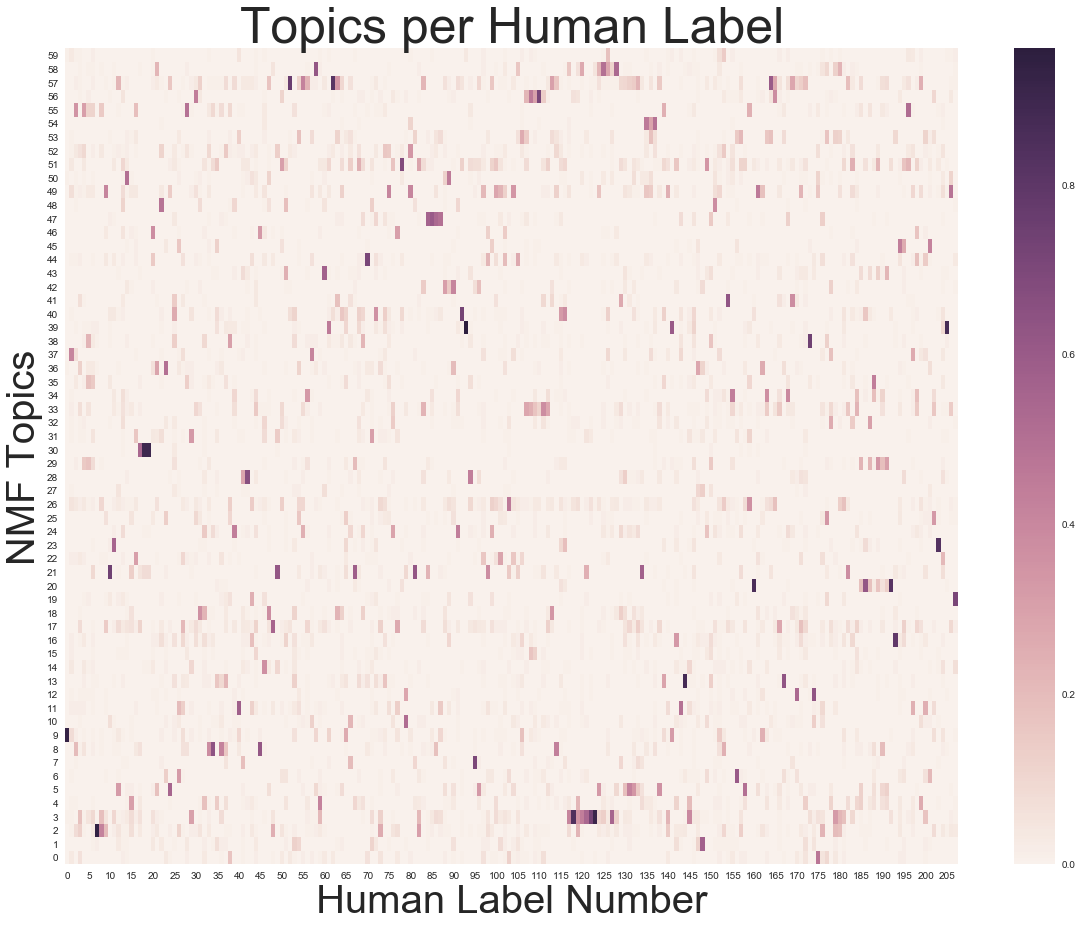

In [59]:
import seaborn as sns

df = df_opinion.drop('label', axis=1)
fig, ax = plt.subplots(1, 1, figsize = (20, 15))
hm = sns.heatmap(df_opinion_labeled.drop('Human Label', axis=1).transpose(), xticklabels=5)
hm.axes.set_title('Topics per Human Label', fontsize=50)
hm.axes.set_xlabel('Human Label Number', fontsize=40)
hm.axes.set_ylabel('NMF Topics', fontsize=40)
hm.axes.set_yticklabels(range(60))
sns.set(font_scale=1)

---

So far it looks like we have a good deal of agreement while still generating more nuance than a single lable. Because the data was loaded in alphebetical order by human topic, we should be able to confirm this tendency by looking at the topic distributions of each individual document in a heatmap. 

---

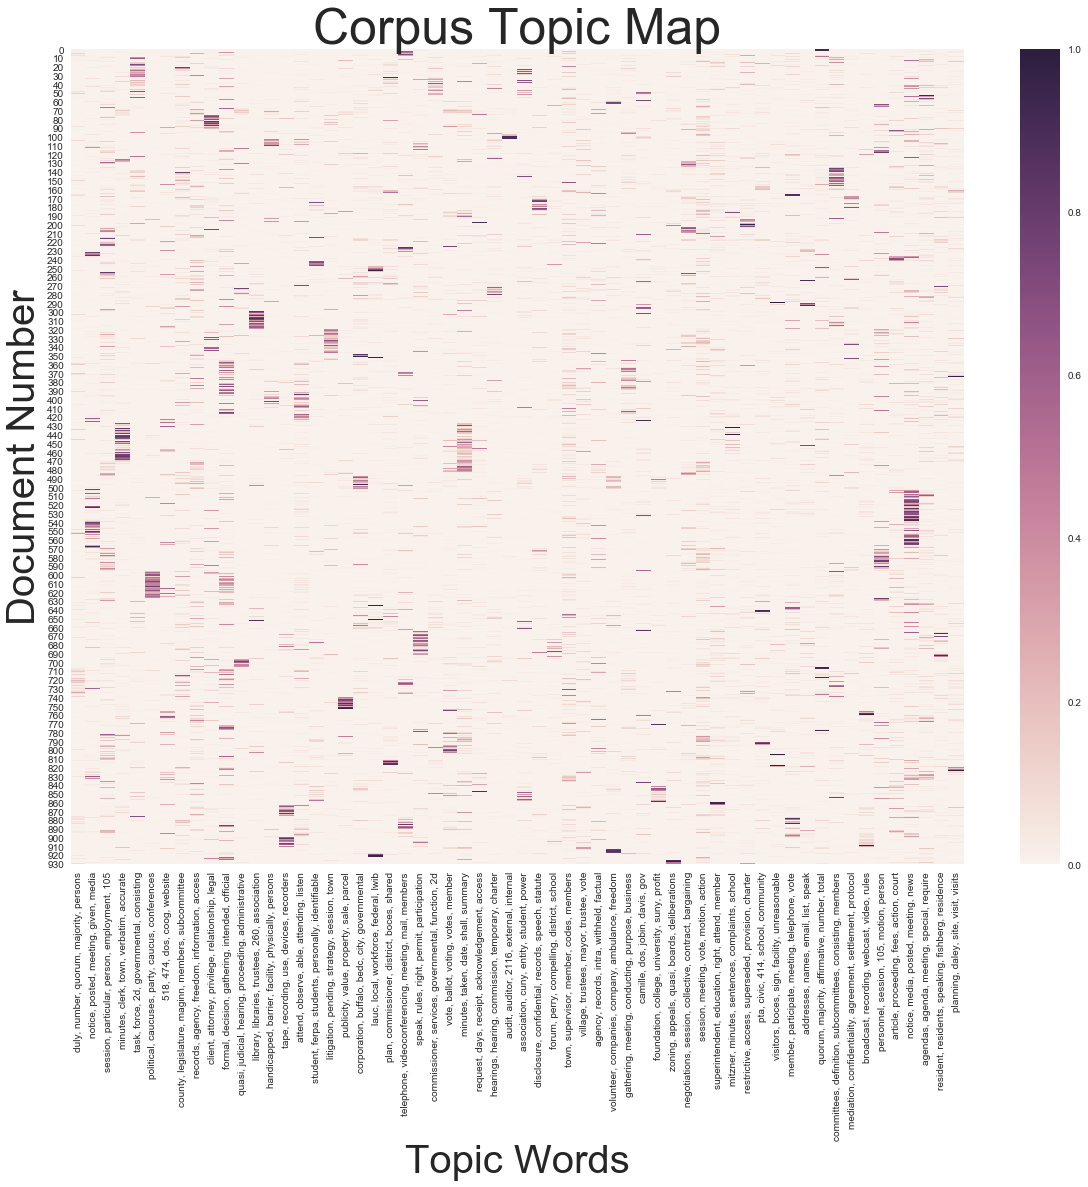

In [60]:
df = df_opinion.drop('label', axis=1)
fig, ax = plt.subplots(1, 1, figsize = (20, 15))
hm = sns.heatmap(df, yticklabels=10)
hm.axes.set_title('Corpus Topic Map', fontsize=50)
hm.axes.set_xlabel('Topic Words', fontsize=40)
hm.axes.set_ylabel('Document Number', fontsize=40)
sns.set(font_scale=1)

<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


## Reducing Noise
---

Topics that account for less than 7% of a document don't contribute very much to our understanding, and they may reduce the signal form more important topics, so we will eliminate any values below .07. Our applications can take advantage of algorithms that optimally handle sparse data, so this cleaning will also imporove performance.

We can also use it as an opportunity to see measure the health of the model. If any documents lost more than 50% of their signal from this cleaning, it means that the model wasn't able to find a good latent topic for the Opinion. That could just be an anomalous Opinion, but if we see it happening a lot then it means we need to reevaluate the model.

---

In [61]:

#these are all of the opinions and their distribution over the latent topics
df_graph = pd.DataFrame(td_opinion_norm).round(2)
df_graph.fillna(value=0, inplace=True)

#to eliminate noise from the data, we drop anything less than .07 from the topic distribution
df_graph.mask(df_graph<.06, 0, inplace=True)

#to make sure we didn't have a lot of data that was primarily made up these noisy fragments
#we sum each opinion's remaining values and filter out any that are below 60
sum_series = df_graph.transpose().sum()
sum_series.where(sum_series<.6).dropna()

43     0.57
176    0.46
257    0.57
259    0.46
281    0.59
283    0.53
645    0.53
655    0.53
659    0.58
720    0.57
810    0.54
835    0.58
868    0.55
918    0.56
dtype: float64

---

Only 1 was below the threshold we set, and only 6 were close to it. At this point we can inspect those documents, but no matter what we should save these results in the data cleaning log before we renormalize the values. After we apply  l1 normalization, topics per Opinion will again sum to 1 with the noise eliminated. Now we can evaluate the concentration of topics by sorting the Opinions by topic, starting with the topics with the highest cumulative score in the corpus. To the degree that the topics are concentrated, this will cause dark clumps to appear in the heatmap.

---

In [62]:
df_graph = pd.DataFrame(normalize(df_graph, norm='l1', axis=1).round(2))

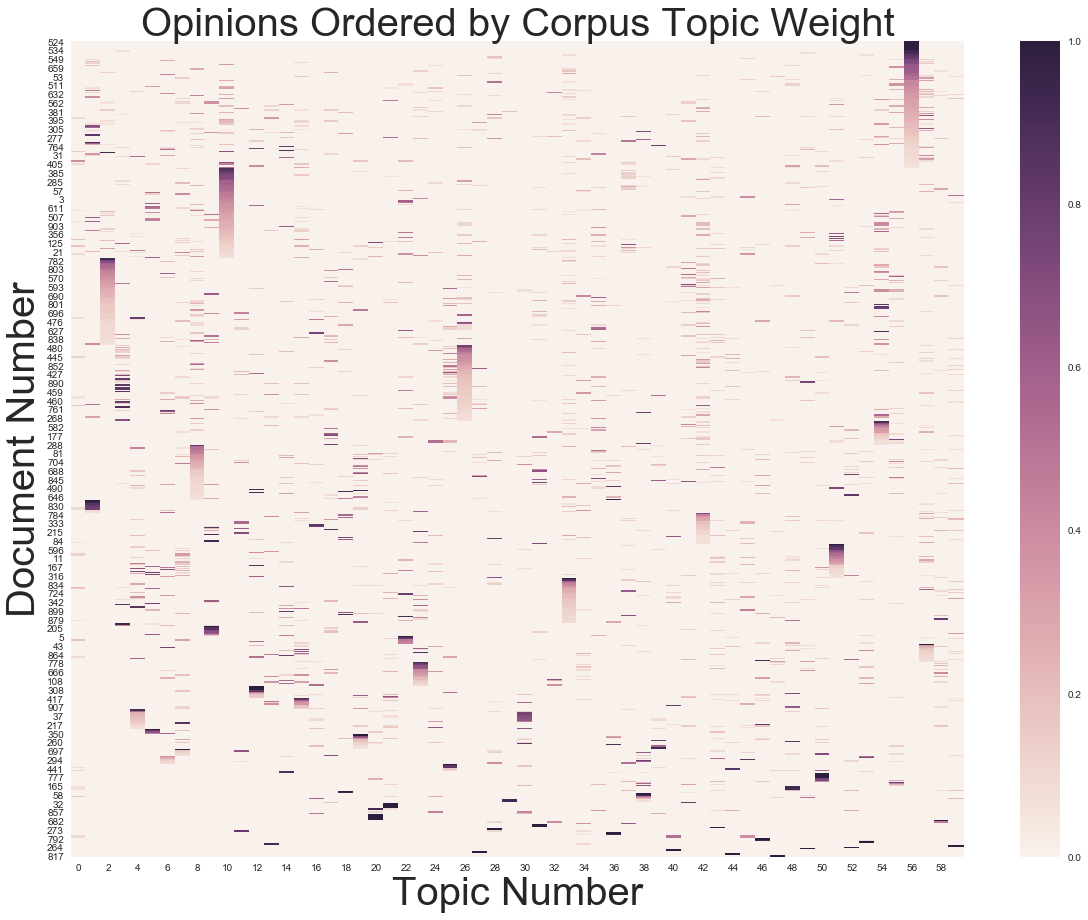

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (20, 15))

hm = sns.heatmap(df_graph.sort_values([i for i in df_graph.sum().sort_values(ascending=False).index], ascending=False), 
            xticklabels=2, yticklabels=10)
hm.axes.set_title('Opinions Ordered by Corpus Topic Weight', fontsize=40)
hm.axes.set_xlabel('Topic Number', fontsize=40)
hm.axes.set_ylabel('Document Number', fontsize=40)
sns.set(font_scale=1)


---

We can further inspect a particular topic by sorting on that topic. This can help us see connections among differnt topics, and give us ideas about how to detect them automatically.

---

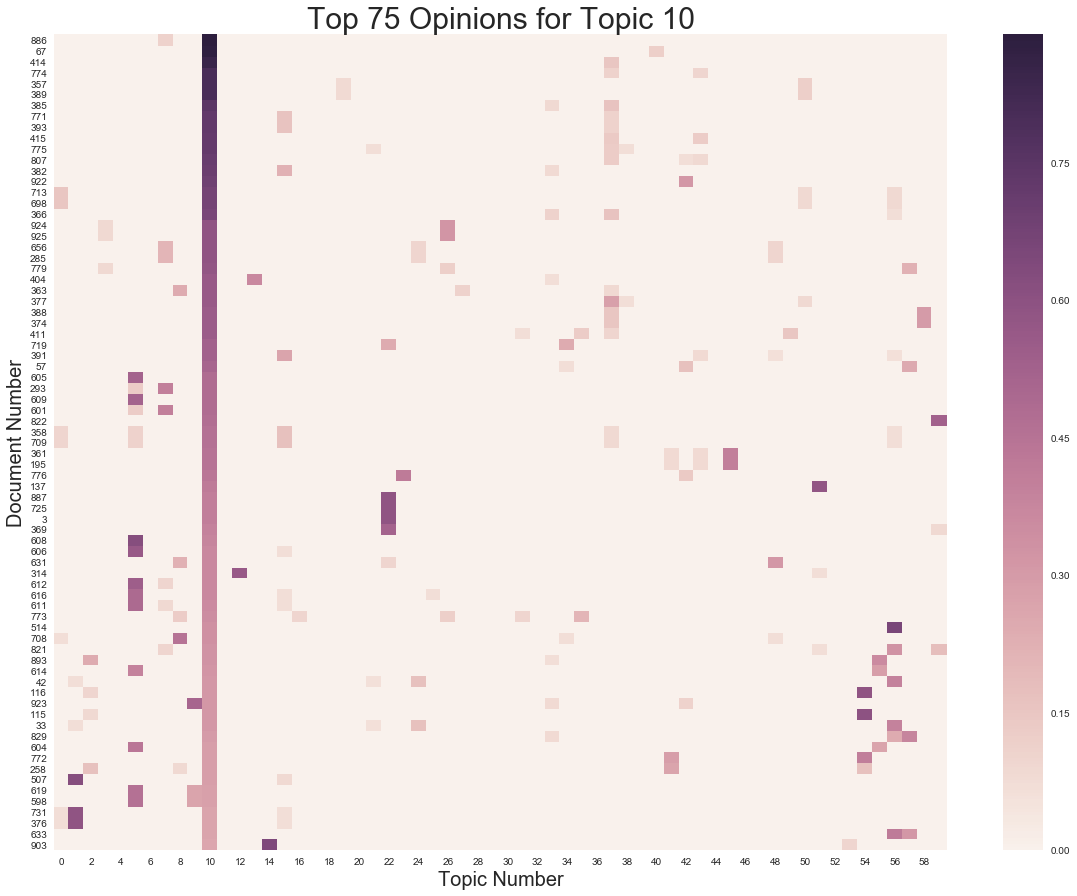

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (20, 15))

hm = sns.heatmap(df_graph.sort_values([10], ascending=False)[:75], 
            xticklabels=2)
hm.axes.set_title('Top 75 Opinions for Topic 10', fontsize=30)
hm.axes.set_xlabel('Topic Number', fontsize=20)
hm.axes.set_ylabel('Document Number', fontsize=20)
sns.set(font_scale=1)

---
<div style="text-align: right"> { [Table of Contents](#Table-of-Contents) }</div>


## Topic and Document Fingerprints

We can now use these topic and document distributions to represent the documents and topics within a database. This allows us to conduct powerful searches or document comparsions quickly using vector arithmetic. 

---

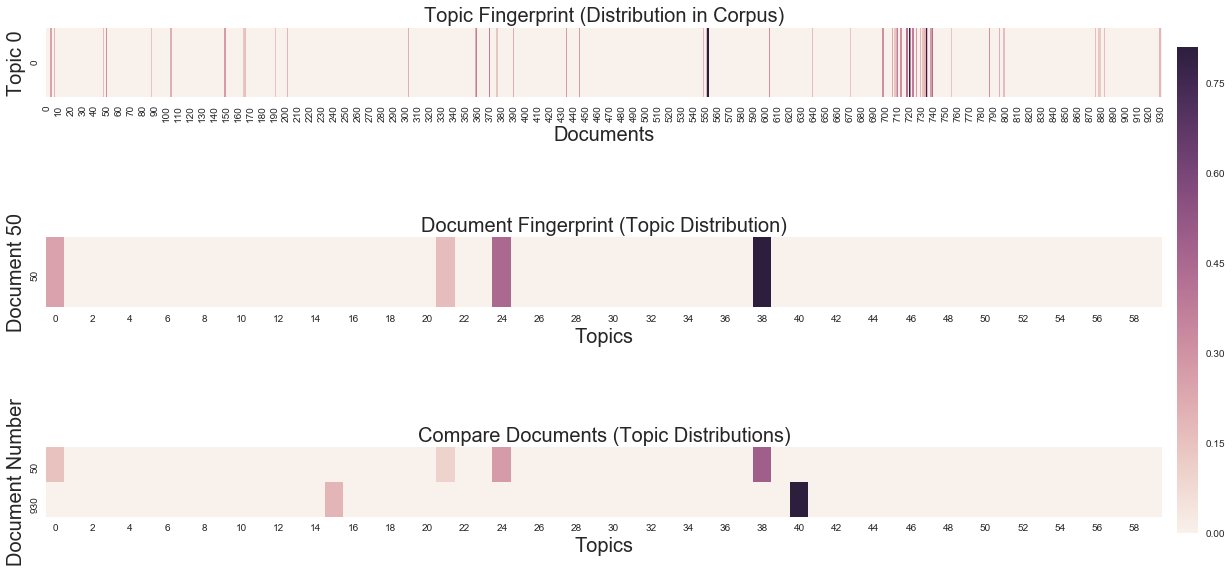

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,  figsize = (20, 9))

cbar_ax = fig.add_axes([.91,.1,.015,.75])
plt.subplots_adjust(hspace = 2)

hm1 = sns.heatmap(df_graph.transpose()[:1], 
            xticklabels=10, ax=ax1, cbar_ax=cbar_ax)

hm1.axes.set_title('Topic Fingerprint (Distribution in Corpus)', fontsize=20)
hm1.axes.set_xlabel('Documents', fontsize=20)
hm1.axes.set_ylabel('Topic 0', fontsize=20)
sns.set(font_scale=1)


hm2 = sns.heatmap(df_graph.iloc[[50]], 
            xticklabels=2, ax=ax2,cbar_ax=cbar_ax)
hm2.axes.set_title('Document Fingerprint (Topic Distribution)', fontsize=20)
hm2.axes.set_xlabel('Topics', fontsize=20)
hm2.axes.set_ylabel('Document 50', fontsize=20)
sns.set(font_scale=1)

hm3 = sns.heatmap(df_graph.iloc[[50,930]], 
            xticklabels=2, ax=ax3,cbar_ax=cbar_ax)
hm3.axes.set_title('Compare Documents (Topic Distributions)', fontsize=20)
hm3.axes.set_xlabel('Topics', fontsize=20)
hm3.axes.set_ylabel('Document Number', fontsize=20)
sns.set(font_scale=1)

## Find Documents with Matching Topic Fingerprints

We can compare fingerprints using a technique called Cosine Similarity. Essentially, we measure the distance between two topic distributions as if they were lines passing trough the topic space. This function takes an Opinion and finds the Opinion in the corpus with the most similar topic distribution and displays them both.

In [66]:
from numpy import dot
from numpy.linalg import norm

def find_similar(df, index):
    top_score = 0
    match = 0
    a = df.iloc[index]
    for i in range(len(df)):
        if i == index:
            pass
        else:
            b = df.iloc[i]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            if cos_sim > top_score:
                match = i
                top_score = cos_sim
                
    fig, (ax1,ax2) = plt.subplots(2,1, figsize = (20,6))
    cbar_ax = fig.add_axes([.91,.1,.015,.75])
    plt.subplots_adjust(hspace = .1)

    hm1 = sns.heatmap(df.iloc[[index]], xticklabels = False, ax=ax1, cbar_ax = cbar_ax)
    hm1.axes.set_title('Target + Match', fontsize=25)
    hm1.axes.set_ylabel('Target Opinion', fontsize=15)
    
    hm2 = sns.heatmap(df.iloc[[match]], xticklabels = 2, ax=ax2, cbar_ax = cbar_ax)
    hm2.axes.set_xlabel('Topic Number', fontsize=20)
    hm2.axes.set_ylabel('Match Opinion', fontsize=15)
    
        
    

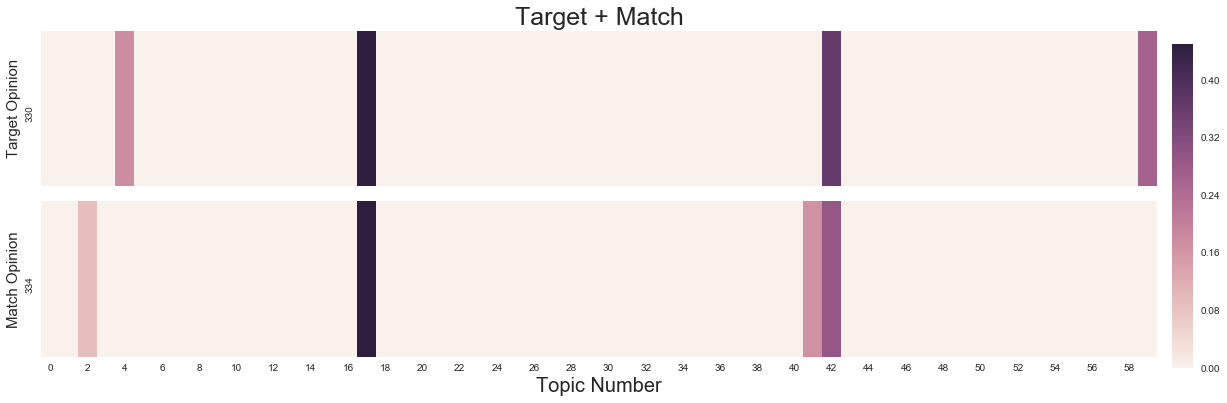

In [67]:
find_similar(df_graph, 330)
